In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import ar_select_order

In [2]:
#import data
main_folder = Path.cwd().parent.parent

data_folder = main_folder / 'data/Norbert'
plots_folder = main_folder / 'Plots/Norbert'
scripts_folder = main_folder / 'scripts/Norbert'

df = pd.read_csv(data_folder / 'deaths_malaysia.csv')

In [3]:
df.drop(columns = ['deaths_new', 'deaths_bid', 'deaths_new_dod', 'deaths_bid_dod', 'deaths_pvax', 'deaths_boost', 'deaths_tat'], inplace = True)
df.columns = ['date', 'unvax', 'fvax']
df.set_index('date', inplace = True)
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
print(df)


            unvax  fvax
date                   
2020-03-17      2     0
2020-03-18      0     0
2020-03-19      0     0
2020-03-20      1     0
2020-03-21      4     0
...           ...   ...
2025-04-29      0     0
2025-04-30      0     0
2025-05-01      0     0
2025-05-02      0     0
2025-05-03      0     0

[1874 rows x 2 columns]


ADF Statistic for unvax: -3.0963655667430716
p-value for unvax: 0.026823324581619963
ADF Statistic for fvax: -3.5181435549832507
p-value for fvax: 0.0075331737446544915
                            AutoReg Model Results                             
Dep. Variable:                  unvax   No. Observations:                 1874
Model:                     AutoReg(4)   Log Likelihood               -5649.105
Method:               Conditional MLE   S.D. of innovations              4.963
Date:                Fri, 23 May 2025   AIC                          11310.210
Time:                        16:44:36   BIC                          11343.412
Sample:                    03-21-2020   HQIC                         11322.443
                         - 05-03-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0594      0.122      0.4

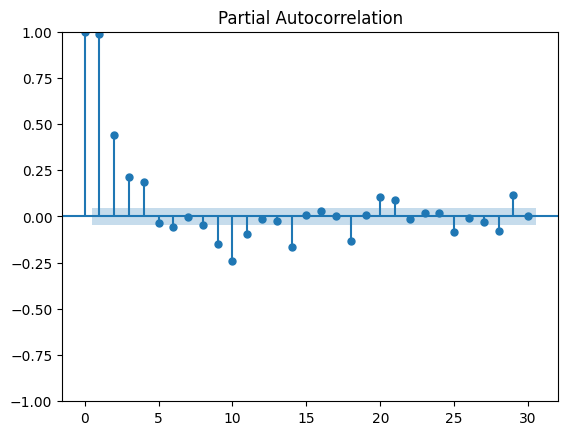

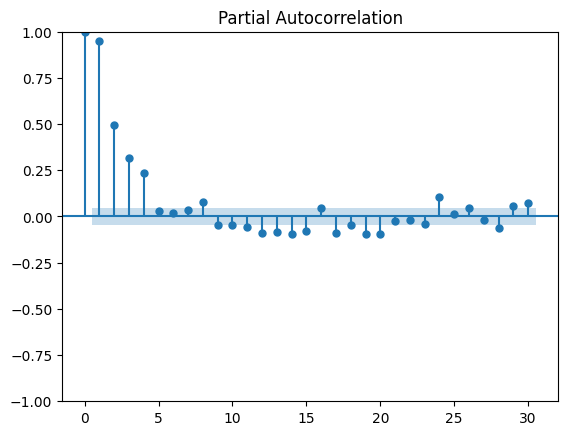

In [262]:
#check data stationarity
adf_result = adfuller(df['unvax'].dropna())
print('ADF Statistic for unvax:', adf_result[0])  # More negative = stronger evidence for stationarity
print('p-value for unvax:', adf_result[1])

adf_result = adfuller(df['fvax'].dropna())
print('ADF Statistic for fvax:', adf_result[0])  # More negative = stronger evidence for stationarity
print('p-value for fvax:', adf_result[1])

pcaf_unvax = plot_pacf(df['unvax'], lags = 30)
pcaf_fvax = plot_pacf(df['fvax'], lags = 30)


model_unvax = AutoReg(df['unvax'], lags = 4, old_names=False)
model_unvax_fitted = model_unvax.fit()
print(model_unvax_fitted.summary())

model_fvax = AutoReg(df['fvax'], lags = 4, old_names=False)
model_fvax_fitted = model_fvax.fit()
print(model_fvax_fitted.summary())


In [232]:
forecast_steps = 3652
forecast_diff_unvax = model_unvax_fitted.predict(start = len(df['unvax']), end = len(df['unvax']) + forecast_steps-1, dynamic = False)
forecast_diff_fvax = model_fvax_fitted.predict(start = len(df['fvax']), end = len(df['fvax']) + forecast_steps-1, dynamic = False)

last_deaths_unvax = df['unvax'].iloc[-1]
last_deaths_fvax = df['fvax'].iloc[-1]

forecast_deaths_unvax = last_deaths_unvax + forecast_diff_unvax
forecast_deaths_fvax = last_deaths_fvax + forecast_diff_fvax

forecast_date = pd.date_range(start = df.index[-1] + pd.Timedelta(days =1), periods = forecast_steps, freq = 'D')

forecast_df_unvax = pd.DataFrame({'data': forecast_date, 'deaths': forecast_deaths_unvax})
forecast_df_fvax = pd.DataFrame({'data': forecast_date, 'deaths': forecast_deaths_fvax})

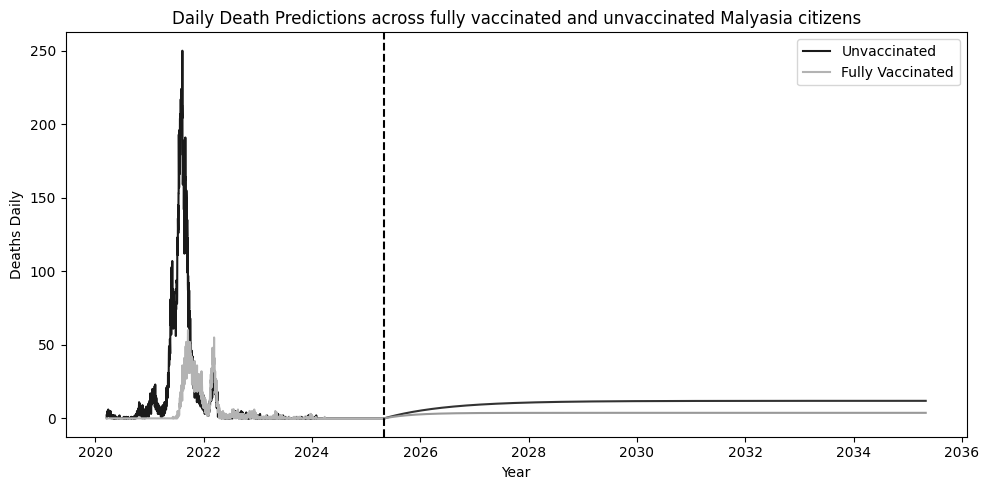

In [259]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['unvax'],  label = 'Unvaccinated', color = '0.1')
plt.plot(df.index, df['fvax'],label = 'Fully Vaccinated', color = '0.7')
plt.plot(forecast_df_unvax.index, forecast_df_unvax['deaths'], color = '0.2')
plt.plot(forecast_df_fvax.index, forecast_df_fvax['deaths'], color = '0.6')
plt.axvline(x = df.index[-1], linestyle = '--', color = 'black')
plt.xlabel('Year')
plt.ylabel('Deaths Daily')
plt.title('Daily Death Predictions across fully vaccinated and unvaccinated Malyasia citizens')
plt.legend()
plt.tight_layout()
plt.savefig(plots_folder/'daily_deaths.jpg')



In [235]:
last_deaths_unvax = df['unvax'].iloc[-1]
last_deaths_fvax = df['fvax'].iloc[-1]

forecast_deaths_unvax = last_deaths_unvax + forecast_diff_unvax
forecast_deaths_fvax = last_deaths_fvax + forecast_diff_fvax

forecast_date = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

forecast_df_unvax = pd.DataFrame({'data': forecast_date, 'deaths': forecast_deaths_unvax})
forecast_df_fvax = pd.DataFrame({'data': forecast_date, 'deaths': forecast_deaths_fvax})

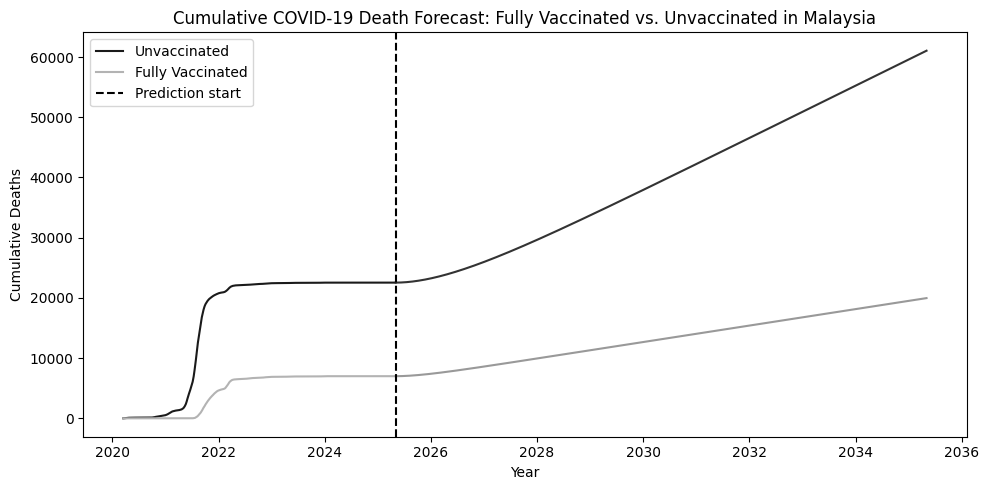

In [256]:
cum_df = df.cumsum()
last_cum_deaths_unvax = cum_df['unvax'].iloc[-1]
last_cum_deaths_fvax = cum_df['fvax'].iloc[-1]

forecast_deaths_cum_unvax = last_cum_deaths_unvax + forecast_diff_unvax.cumsum()
forecast_deaths_cum_fvax = last_cum_deaths_fvax + forecast_diff_fvax.cumsum()
forecast_date = pd.date_range(start = df.index[-1] + pd.Timedelta(days =1), periods = forecast_steps, freq = 'D')

forecast_df_deaths_cum_unvax = pd.DataFrame({'data': forecast_date, 'deaths': forecast_deaths_cum_unvax})
forecast_df_deaths_cum_fvax = pd.DataFrame({'data': forecast_date, 'deaths': forecast_deaths_cum_fvax})

plt.figure(figsize=(10, 5))
plt.plot(cum_df.index, cum_df['unvax'], label = 'Unvaccinated', color = '0.1')
plt.plot(cum_df.index, cum_df['fvax'], label = 'Fully Vaccinated', color = '0.7')
plt.plot(forecast_df_unvax.index, forecast_df_deaths_cum_unvax['deaths'], color = '0.2')
plt.plot(forecast_df_fvax.index, forecast_df_deaths_cum_fvax['deaths'], color = '0.6')
plt.axvline(x = cum_df.index[-1], linestyle = '--', color = 'black', label = 'Prediction start')
plt.xlabel('Year')
plt.ylabel('Cumulative Deaths')
plt.title('Cumulative COVID-19 Death Forecast: Fully Vaccinated vs. Unvaccinated in Malaysia')
plt.tight_layout()
plt.legend()
plt.savefig(plots_folder/'cumulative_deaths.jpg')
